# Assignment 2
## 1. Properties of CNNs
### Question 1.2 (a)

In this first part, we will train a CNN model over the dataset CIFAR-10. This dataset contains 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship and truck. 

First, let's load the data:

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [7]:
# Import data from CIFAR-10
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Create a function to display the first 25 images of a dataset with their corresponding class name and use it over `train_data`. 

Hint: `class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]`, where the labels are the corresponding index. 
   

In [8]:
def display_first_few_images(data):
    #######################
    # PUT YOUR CODE HERE  #
    #######################

    class_names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    plt.figure(figsize=(8,8))
    for i in range(25):
        img, label = data[i]
        # convert tensor (C,H,W) to numpy image (H,W,C)
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1, 2, 0).cpu().numpy()
        else:
            img_np = np.array(img)
            # scale uint8 to [0,1] for imshow
            if img_np.dtype == np.uint8:
                img_np = img_np.astype(np.float32) / 255.0

        plt.subplot(5, 5, i+1)
        plt.imshow(img_np)
        plt.title(class_names[int(label)])
        plt.axis('off')
    plt.tight_layout()

    #######################
    # END OF YOUR CODE    #
    #######################

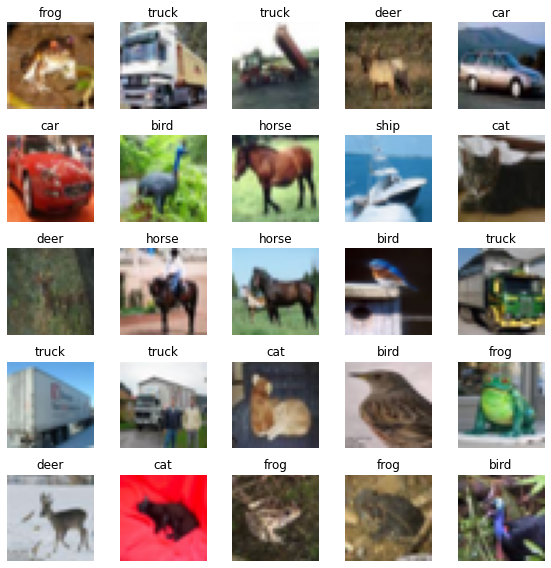

In [9]:
display_first_few_images(train_data)

Now, we will load and train a small CNN model! In the following cells you can check the architecture of the model and the designed function for its training.

Note: You shouldn't need Snellius to run it. Either Google Collab or your local computer should be enough.

In [10]:
# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function for training the model
def train(model, train_loader, epochs = 10):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

In [11]:
# Initialize the model 
model = CNN().to(device)

# Train the model
train(model, train_loader)

  0%|          | 3/782 [00:00<00:34, 22.28it/s]

Epoch 1, Loss: 1.5976


  0%|          | 3/782 [00:00<00:33, 23.53it/s]

Epoch 2, Loss: 1.2072


  0%|          | 3/782 [00:00<00:33, 23.31it/s]

Epoch 3, Loss: 1.0450


  0%|          | 2/782 [00:00<00:41, 18.86it/s]

Epoch 4, Loss: 0.9320


  0%|          | 2/782 [00:00<00:39, 19.55it/s]

Epoch 5, Loss: 0.8563


  0%|          | 2/782 [00:00<00:43, 18.09it/s]

Epoch 6, Loss: 0.7918


  0%|          | 3/782 [00:00<00:28, 26.90it/s]

Epoch 7, Loss: 0.7437


  0%|          | 3/782 [00:00<00:36, 21.57it/s]

Epoch 8, Loss: 0.7008


  0%|          | 2/782 [00:00<00:43, 17.94it/s]

Epoch 9, Loss: 0.6562


100%|██████████| 782/782 [00:36<00:00, 21.21it/s]

Epoch 10, Loss: 0.6263


Now, we want to check the performance of the trained model for the test dataset when rotating the images 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330 and 360 degrees.

For this, you need to first create the function `get_acc_per_angle` that computes the accuracies_per_angle for a given model. You should create a `rotated_test_data` and a `rotated_test_loader`, from which taking the images and labels to give as input to the `inference` function that is provided to you in the following cell. 

Then, create a `plot` function that plots the accuracy of the model per angle of rotation of the images.   

Hint: Check how we used transformations in section a.

In [14]:
def inference(model, images, labels):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    return predictions

In [21]:
def get_acc_per_angle(model):
    angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
    angle_accuracies = []

    with torch.no_grad():
        for angle in angles:
            #######################
            # PUT YOUR CODE HERE  #
            #######################
            transform = transforms.Compose([
                transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
                transforms.ToTensor()
            ])

            rotated_test_data = test_data
            rotated_test_data.transform = transform
            
            rotated_test_loader = torch.utils.data.DataLoader(
                rotated_test_data, 
                batch_size=128, 
                shuffle=False)
            
            correct_preds = 0
            total_samples = 0
            
            for images, labels in rotated_test_loader:
                predictions = inference(model, images, labels)
                labels = labels.to(device)
                
                correct_preds += (predictions == labels).sum().item()
                total_samples += labels.size(0)
        
            accuracy = correct_preds / total_samples
            angle_accuracies.append(accuracy)
            #######################
            # END OF YOUR CODE    #
            #######################
    
    return angles, angle_accuracies          

In [23]:
angles, angle_accuracies = get_acc_per_angle(model)

In [32]:
# Plot accuracy vs rotation angle
def plot(angles, angle_accuracies):
            #######################
            # PUT YOUR CODE HERE  #
            #######################    
            plt.figure(figsize=(10,5))
            plt.plot(angles, angle_accuracies, marker='x')
            plt.grid(True)
            plt.xticks(angles)
            plt.show()
            #######################
            # END OF YOUR CODE    #
            #######################

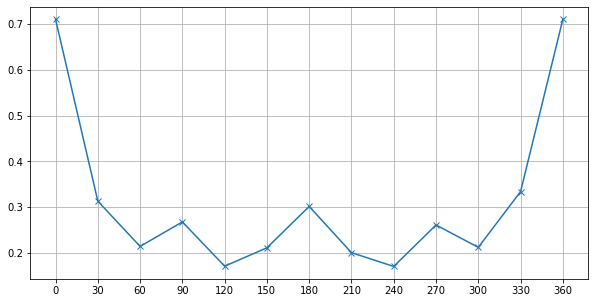

In [33]:
plot(angles,angle_accuracies)

### Question 1.2 (b)

As said in the pdf, now we will first train a model with the same architecture as the previous one (this is, you can use the same to initialize the model as before), changing the train dataset so that it contains _random rotations_ of angles of up to 360 degrees. For this, create a new `train_augmentation_transform` to create the train augmented dataset.

Hint: Check how we used transformations in Question 1.2 (a)

Files already downloaded and verified


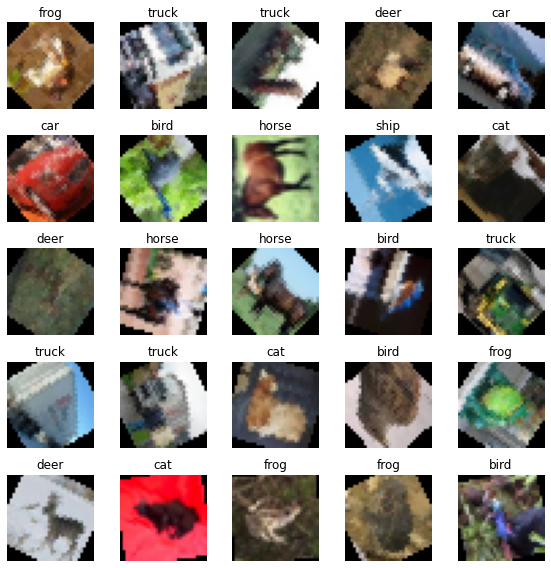

In [34]:
# Create the new train data and loader and visualize it

#######################
# PUT YOUR CODE HERE  #
#######################
train_augmentation_transform = transforms.Compose([
                transforms.RandomRotation((0,360)),
                transforms.ToTensor()
            ])
#######################
# END OF YOUR CODE    #
#######################

train_augmented_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_augmentation_transform)
train_augmented_loader = torch.utils.data.DataLoader(train_augmented_data, batch_size=64, shuffle=True)


display_first_few_images(train_augmented_data)

As said, we will now initialize the new model and train it over the `train_augmented_loader` you just created. Initialized the new model as we did in the previous question and train it using the `train` function. 

Note: Again, you shouldn't need Snellius to run it 

In [38]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Initialize the model 
model_aug = CNN().to(device)

# Train the model
train(model_aug, train_augmented_loader)

#######################
# END OF YOUR CODE    #
#######################

  0%|          | 3/782 [00:00<00:31, 24.36it/s]

Epoch 1, Loss: 1.9264


  1%|          | 4/782 [00:00<00:22, 34.83it/s]

Epoch 2, Loss: 1.6816


  1%|          | 4/782 [00:00<00:23, 32.74it/s]

Epoch 3, Loss: 1.5787


  1%|          | 4/782 [00:00<00:22, 34.23it/s]

Epoch 4, Loss: 1.5201


  1%|          | 4/782 [00:00<00:22, 34.44it/s]

Epoch 5, Loss: 1.4672


  1%|          | 4/782 [00:00<00:21, 35.97it/s]

Epoch 6, Loss: 1.4275


  1%|          | 4/782 [00:00<00:25, 30.38it/s]

Epoch 7, Loss: 1.3969


  0%|          | 3/782 [00:00<00:29, 26.22it/s]

Epoch 8, Loss: 1.3648


  1%|          | 4/782 [00:00<00:23, 33.43it/s]

Epoch 9, Loss: 1.3378


100%|██████████| 782/782 [00:22<00:00, 35.25it/s]

Epoch 10, Loss: 1.3232


Now, evaluate its performance by running inference over the dataset when rotating the images 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330 and 360 degrees, and plotting the model's accuracy respect to the angle of rotation of the test dataset. You can use `get_acc_per_angle` and `plot` functions you defined in Question 1.2 (a)!

Hint: The test data is the same as in Question 1.2 (a)

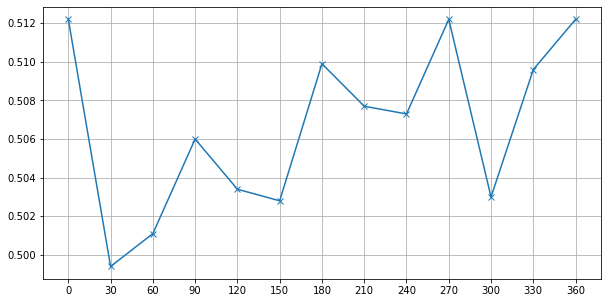

In [39]:
#######################
# PUT YOUR CODE HERE  #
#######################
angles_aug, angle_accuracies_aug = get_acc_per_angle(model_aug)
plot(angles=angles_aug, angle_accuracies=angle_accuracies_aug)

#######################
# END OF YOUR CODE    #
#######################